## Assessment of study-dataset splitting

<b>source:</b> "https://github.com/LungCellAtlas/HLCA_reproducibility/blob/main/notebooks/1_building_and_annotating_the_atlas_core/01b_study_splitting_by_batch_effect_assessment.ipynb"

In this notebook we will determine which of the studies that have substantial differences in experimental conditions within study will need to be split into separate datasets (datasets will be the "batches" used for integration).

### Import modules

In [43]:
import scanpy as sc
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from tqdm.autonotebook import tqdm as tqdm

In [2]:
def check_if_nan(value):
    """return Boolean version of value that is True if value is
    some type of NaN (e.g. np.nan, None, "nan" etc). 
    Example use:
    none_entries = subadata.obs.applymap(check_if_nan)
    subadata.obs = subadata.obs.mask(none_entries.values)
    """
    if value == "nan":
        return True
    elif value == None:
        return True
    if isinstance(value, float):
        if np.isnan(value):
            return True
    if value == "ND":
        return True
    return False

### Set paths:

In [3]:
# path of partly preprocessed HLCA file used in this notebook:
adata_path = "/home/h/hollenberg/MaPra/merged_data.h5ad"
# path to results directory:
dir_out = "/home/h/hollenberg/MaPra"

### Perpare groups to check batch effect

In [4]:
adata = sc.read(adata_path)

In [5]:
keywords = ['misharin', 'tsukui', 'schiller', 'peyser', 'xie']

# get project information
for idx, row in adata.obs.iterrows():
    string_value = row['batch']
    for keyword in keywords:
        if keyword in string_value:
            adata.obs.at[idx, 'project'] = keyword
            break

In [6]:
adata.obs.project.unique()

array(['xie', 'peyser', 'tsukui', 'misharin', 'schiller'], dtype=object)

In [7]:
adata.obs.condition.unique()

['untreated', 'bleomycin', 'saline', 'nintedanib', 'asbestos']
Categories (5, object): ['untreated', 'asbestos', 'bleomycin', 'nintedanib', 'saline']

In [8]:
# combination of batch and project doesen't add add information -> useless
#adata.obs['project-batch'] = adata.obs['project'].astype(str).str.cat(adata.obs['batch'].astype(str), sep='-')
adata.obs['project-annotation'] = adata.obs['project'].astype(str).str.cat(adata.obs['manual_celltype_annotation'].astype(str), sep='-')
adata.obs['cond-proj'] = adata.obs['condition'].astype(str).str.cat(adata.obs['project'].astype(str), sep='-')
adata.obs['batch-annotation'] = adata.obs['batch'].astype(str).str.cat(adata.obs['manual_celltype_annotation'].astype(str), sep='-')

In [9]:
adata.obs

,author_annotation,scDblFinder_score,scDblFinder_class,manual_celltype_annotation,batch,condition,doublet_score,predicted_doublet,timepoint,author_annotation_coarse,...,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,low_hierarchy,high_hierarchy,project,project-annotation,cond-proj,batch-annotation
AAACCTGAGGACATTA-1_xie,Col13a1,0.021293,singlet,Myofibroblasts,1_xie,untreated,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,Adventitial fibroblasts ∈ Myofibroblasts ∈ Myo...,Group1,xie,xie-Myofibroblasts,untreated-xie,1_xie-Myofibroblasts
AAACCTGCAGTCGTGC-1_xie,Myofibroblasts,0.000934,singlet,Peribronchial fibroblasts,1_xie,untreated,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,Peribronchial fibroblasts = Peribronchial fibr...,Group13,xie,xie-Peribronchial fibroblasts,untreated-xie,1_xie-Peribronchial fibroblasts
AAACCTGCATGAAGTA-1_xie,Lipofibroblasts,0.000118,singlet,Alveolar macrophages,1_xie,untreated,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,UNRESOLVED = Alveolar macrophages = Alveolar m...,Group16,xie,xie-Alveolar macrophages,untreated-xie,1_xie-Alveolar macrophages
AAACCTGTCTCGCATC-1_xie,Myofibroblasts,0.000478,singlet,Peribronchial fibroblasts,1_xie,untreated,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,Peribronchial fibroblasts = Peribronchial fibr...,Group13,xie,xie-Peribronchial fibroblasts,untreated-xie,1_xie-Peribronchial fibroblasts
AAACGGGTCCTAGAAC-1_xie,Myofibroblasts,0.000669,singlet,Peribronchial fibroblasts,1_xie,untreated,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,Peribronchial fibroblasts = Peribronchial fibr...,Group13,xie,xie-Peribronchial fibroblasts,untreated-xie,1_xie-Peribronchial fibroblasts
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29291_schiller,Ciliated cells,NaN,NaN,Alveolar fibroblasts,muc4657_schiller,untreated,NaN,NaN,d21,ciliated_cells,...,0.0,0.0,0.0,0.0,UNRESOLVED = UNRESOLVED = UNRESOLVED = UNRESOL...,Group20,schiller,schiller-Alveolar fibroblasts,untreated-schiller,muc4657_schiller-Alveolar fibroblasts
29292_schiller,AT2 cells,NaN,NaN,AT2,muc4657_schiller,untreated,NaN,NaN,d21,alv_epithelium,...,0.0,0.0,0.0,0.0,Epithelial = AT2 = AT2 ∈ Epithelial = AT2,Group7,schiller,schiller-AT2,untreated-schiller,muc4657_schiller-AT2
29293_schiller,Ciliated cells,NaN,NaN,Alveolar fibroblasts,muc4657_schiller,untreated,NaN,NaN,d21,ciliated_cells,...,0.0,0.0,0.0,0.0,UNRESOLVED = UNRESOLVED = UNRESOLVED = UNRESOL...,Group20,schiller,schiller-Alveolar fibroblasts,untreated-schiller,muc4657_schiller-Alveolar fibroblasts
29294_schiller,AT2 cells,NaN,NaN,AT2,muc4657_schiller,untreated,NaN,NaN,d21,alv_epithelium,...,0.0,0.0,0.0,0.0,Epithelial = AT2 = AT2 ∈ Epithelial = AT2,Group7,schiller,schiller-AT2,untreated-schiller,muc4657_schiller-AT2


specifiy covariates we want to check (we will quantify their correlation with the 1st 50 PCs, to see how much variance they can each explain):

In [10]:
covariates = [
    "project", # ['xie', 'peyser', 'tsukui', 'misharin', 'schiller']
    "batch", # ['0_misharin', '0_tsukui', '1_misharin', '1_tsukui', ...,]
    "condition", # ['untreated', 'asbestos', 'bleomycin', 'nintedanib', 'saline']
    "manual_celltype_annotation",
    "project-annotation",
    "batch-annotation",
    "cond-proj"
]

Create shuffled assignment of single cell platform (and processing site if included), to compare actual variance explained to variance explained expected by random. We will assign all cells of the same sample to the same value.

In [11]:
# create shuffled version of single cell platform, and of Processing_site:
sample_to_covariate = pd.DataFrame()
covariates_to_shuffle = [
    "project", # ['xie', 'peyser', 'tsukui', 'misharin', 'schiller']
    "condition", # ['untreated', 'asbestos', 'bleomycin', 'nintedanib', 'saline']
    "cond-proj"
]

for group in covariates_to_shuffle:
    sample_to_covariate[group] = adata.obs.groupby("batch").agg({group: "first"})
    
    for i in range(10):
        np.random.shuffle(sample_to_covariate[group])
        adata.obs["shuffled_"+ group + str(i)] = adata.obs["batch"].map(
            dict(
                zip(
                    sample_to_covariate.index,
                    sample_to_covariate[group],
                )
            )
        )
        covariates.append("shuffled_"+ group + str(i))

print(covariates)
sample_to_covariate

/tmp/user/20166/ipykernel_1413347/1071718489.py:13: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(sample_to_covariate[group])
/tmp/user/20166/ipykernel_1413347/1071718489.py:13: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(sample_to_covariate[group])
/tmp/user/20166/ipykernel_1413347/1071718489.py:13: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(sample_to_covariate[group]

['project', 'batch', 'condition', 'manual_celltype_annotation', 'project-annotation', 'batch-annotation', 'cond-proj', 'shuffled_project0', 'shuffled_project1', 'shuffled_project2', 'shuffled_project3', 'shuffled_project4', 'shuffled_project5', 'shuffled_project6', 'shuffled_project7', 'shuffled_project8', 'shuffled_project9', 'shuffled_condition0', 'shuffled_condition1', 'shuffled_condition2', 'shuffled_condition3', 'shuffled_condition4', 'shuffled_condition5', 'shuffled_condition6', 'shuffled_condition7', 'shuffled_condition8', 'shuffled_condition9', 'shuffled_cond-proj0', 'shuffled_cond-proj1', 'shuffled_cond-proj2', 'shuffled_cond-proj3', 'shuffled_cond-proj4', 'shuffled_cond-proj5', 'shuffled_cond-proj6', 'shuffled_cond-proj7', 'shuffled_cond-proj8', 'shuffled_cond-proj9']


,project,condition,cond-proj
batch,,,
0_misharin,schiller,untreated,saline-peyser
0_tsukui,tsukui,untreated,bleomycin-schiller
1_misharin,schiller,bleomycin,bleomycin-schiller
1_tsukui,peyser,untreated,nintedanib-peyser
1_xie,peyser,bleomycin,bleomycin-schiller
2_tsukui,peyser,untreated,untreated-schiller
2_xie,schiller,untreated,bleomycin-tsukui
3_tsukui,schiller,untreated,saline-peyser
3_xie,peyser,bleomycin,bleomycin-schiller


In [12]:
covariates

['project',
 'batch',
 'condition',
 'manual_celltype_annotation',
 'project-annotation',
 'batch-annotation',
 'cond-proj',
 'shuffled_project0',
 'shuffled_project1',
 'shuffled_project2',
 'shuffled_project3',
 'shuffled_project4',
 'shuffled_project5',
 'shuffled_project6',
 'shuffled_project7',
 'shuffled_project8',
 'shuffled_project9',
 'shuffled_condition0',
 'shuffled_condition1',
 'shuffled_condition2',
 'shuffled_condition3',
 'shuffled_condition4',
 'shuffled_condition5',
 'shuffled_condition6',
 'shuffled_condition7',
 'shuffled_condition8',
 'shuffled_condition9',
 'shuffled_cond-proj0',
 'shuffled_cond-proj1',
 'shuffled_cond-proj2',
 'shuffled_cond-proj3',
 'shuffled_cond-proj4',
 'shuffled_cond-proj5',
 'shuffled_cond-proj6',
 'shuffled_cond-proj7',
 'shuffled_cond-proj8',
 'shuffled_cond-proj9']

In [13]:
adata.obs

,author_annotation,scDblFinder_score,scDblFinder_class,manual_celltype_annotation,batch,condition,doublet_score,predicted_doublet,timepoint,author_annotation_coarse,...,shuffled_cond-proj0,shuffled_cond-proj1,shuffled_cond-proj2,shuffled_cond-proj3,shuffled_cond-proj4,shuffled_cond-proj5,shuffled_cond-proj6,shuffled_cond-proj7,shuffled_cond-proj8,shuffled_cond-proj9
AAACCTGAGGACATTA-1_xie,Col13a1,0.021293,singlet,Myofibroblasts,1_xie,untreated,NaN,NaN,NaN,NaN,...,bleomycin-tsukui,saline-peyser,untreated-schiller,bleomycin-peyser,saline-peyser,bleomycin-schiller,bleomycin-schiller,asbestos-misharin,bleomycin-schiller,bleomycin-schiller
AAACCTGCAGTCGTGC-1_xie,Myofibroblasts,0.000934,singlet,Peribronchial fibroblasts,1_xie,untreated,NaN,NaN,NaN,NaN,...,bleomycin-tsukui,saline-peyser,untreated-schiller,bleomycin-peyser,saline-peyser,bleomycin-schiller,bleomycin-schiller,asbestos-misharin,bleomycin-schiller,bleomycin-schiller
AAACCTGCATGAAGTA-1_xie,Lipofibroblasts,0.000118,singlet,Alveolar macrophages,1_xie,untreated,NaN,NaN,NaN,NaN,...,bleomycin-tsukui,saline-peyser,untreated-schiller,bleomycin-peyser,saline-peyser,bleomycin-schiller,bleomycin-schiller,asbestos-misharin,bleomycin-schiller,bleomycin-schiller
AAACCTGTCTCGCATC-1_xie,Myofibroblasts,0.000478,singlet,Peribronchial fibroblasts,1_xie,untreated,NaN,NaN,NaN,NaN,...,bleomycin-tsukui,saline-peyser,untreated-schiller,bleomycin-peyser,saline-peyser,bleomycin-schiller,bleomycin-schiller,asbestos-misharin,bleomycin-schiller,bleomycin-schiller
AAACGGGTCCTAGAAC-1_xie,Myofibroblasts,0.000669,singlet,Peribronchial fibroblasts,1_xie,untreated,NaN,NaN,NaN,NaN,...,bleomycin-tsukui,saline-peyser,untreated-schiller,bleomycin-peyser,saline-peyser,bleomycin-schiller,bleomycin-schiller,asbestos-misharin,bleomycin-schiller,bleomycin-schiller
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29291_schiller,Ciliated cells,NaN,NaN,Alveolar fibroblasts,muc4657_schiller,untreated,NaN,NaN,d21,ciliated_cells,...,untreated-schiller,bleomycin-xie,untreated-schiller,untreated-schiller,saline-peyser,untreated-xie,bleomycin-tsukui,bleomycin-peyser,bleomycin-peyser,untreated-xie
29292_schiller,AT2 cells,NaN,NaN,AT2,muc4657_schiller,untreated,NaN,NaN,d21,alv_epithelium,...,untreated-schiller,bleomycin-xie,untreated-schiller,untreated-schiller,saline-peyser,untreated-xie,bleomycin-tsukui,bleomycin-peyser,bleomycin-peyser,untreated-xie
29293_schiller,Ciliated cells,NaN,NaN,Alveolar fibroblasts,muc4657_schiller,untreated,NaN,NaN,d21,ciliated_cells,...,untreated-schiller,bleomycin-xie,untreated-schiller,untreated-schiller,saline-peyser,untreated-xie,bleomycin-tsukui,bleomycin-peyser,bleomycin-peyser,untreated-xie
29294_schiller,AT2 cells,NaN,NaN,AT2,muc4657_schiller,untreated,NaN,NaN,d21,alv_epithelium,...,untreated-schiller,bleomycin-xie,untreated-schiller,untreated-schiller,saline-peyser,untreated-xie,bleomycin-tsukui,bleomycin-peyser,bleomycin-peyser,untreated-xie


In [14]:
n_pcs = 50

Now check for every covariate, for every PC how much variance among the cells' PC scores the covariate can explain. Add this variance explained per PC up across PCs for every covariate. This will give us the total amount of variance explained per covariate.

In [15]:
var_explained = pd.DataFrame(index=range(n_pcs), columns=covariates + ["overall"])
for pc in tqdm(range(n_pcs)):
    y_true_unfiltered = adata.obsm["X_pca"][:, pc]
    var_explained.loc[pc, "overall"] = np.var(y_true_unfiltered)
    for cov in covariates:
        x = adata.obs[cov].values.copy()
        x_nans = np.vectorize(check_if_nan)(x)
        x = x[~x_nans]
        if len(x) != 0:
            y_true = y_true_unfiltered[~x_nans].reshape(-1, 1)
            if x.dtype in ["float32", "float", "float64"]:
                x = x.reshape(-1, 1)
            else:
                if len(set(x)) == 1:
                    var_explained.loc[pc, cov] = np.nan
                    continue
                x = pd.get_dummies(x)
            lrf = LinearRegression(fit_intercept=True).fit(
                x,
                y_true,
            )
            y_pred = lrf.predict(x)
            var_explained.loc[pc, cov] = np.var(y_pred)
total_variance_explained = np.sum(var_explained, axis=0).sort_values(ascending=False)
total_variance_explained_fractions = (
    total_variance_explained / total_variance_explained["overall"]
)

100%|███████████████████████████████████████████| 50/50 [06:59<00:00,  8.38s/it]


In [16]:
var_explained

,project,batch,condition,manual_celltype_annotation,project-annotation,batch-annotation,cond-proj,shuffled_project0,shuffled_project1,shuffled_project2,...,shuffled_cond-proj1,shuffled_cond-proj2,shuffled_cond-proj3,shuffled_cond-proj4,shuffled_cond-proj5,shuffled_cond-proj6,shuffled_cond-proj7,shuffled_cond-proj8,shuffled_cond-proj9,overall
0,11.92465,22.109715,0.688915,22.232833,34.568027,35.523756,12.433243,0.415986,7.130044,3.411004,...,4.897698,9.643842,10.459263,5.404592,7.807416,9.131732,4.524627,4.954031,8.528001,40.038292
1,6.170529,8.066975,2.748012,13.467031,17.616099,18.375973,7.315805,1.081432,0.575598,0.356971,...,1.450143,2.042511,1.725335,3.051122,1.685167,1.738178,2.196828,1.933683,1.724092,23.579906
2,1.385633,2.314362,1.531167,10.214559,13.366697,13.886172,2.004752,0.201305,0.540881,0.66286,...,0.44177,1.04779,0.574676,1.353525,0.30847,0.555126,0.689622,1.313528,0.376622,16.509029
3,1.134595,1.738168,0.382597,9.761434,11.350805,11.501603,1.242851,0.045576,0.061707,0.27372,...,0.517076,0.73454,0.299758,0.534405,0.192166,0.301448,0.333985,0.519176,0.37558,13.543835
4,0.260231,0.831458,0.032446,3.848627,4.963551,5.323917,0.396574,0.044497,0.045417,0.109778,...,0.230125,0.270457,0.193384,0.183837,0.041023,0.142073,0.174126,0.333898,0.123651,7.241051
5,0.669936,1.474984,0.467455,3.312379,4.227685,4.671118,0.995623,0.174519,0.339643,0.14302,...,0.417004,0.417591,0.337019,0.339832,0.2823,0.309998,0.662225,0.728646,0.377276,6.026707
6,0.157289,0.441548,0.078226,2.003004,2.518307,2.827184,0.24651,0.078605,0.077405,0.013031,...,0.086893,0.095826,0.049878,0.200059,0.103793,0.153827,0.038603,0.129925,0.209755,4.601632
7,0.29728,0.53715,0.254345,2.002425,2.455764,2.662547,0.453629,0.057747,0.104085,0.061688,...,0.121861,0.085406,0.132195,0.154582,0.156843,0.156432,0.16444,0.104815,0.157658,3.941306
8,0.022968,0.284572,0.041834,1.606178,1.856584,2.066937,0.136981,0.016112,0.044785,0.029735,...,0.038233,0.041459,0.040089,0.064387,0.115241,0.088267,0.031225,0.11917,0.031137,3.313376
9,0.139166,0.304945,0.01853,1.459025,1.928381,2.085626,0.153483,0.01379,0.019555,0.016869,...,0.04154,0.090322,0.046473,0.087145,0.027482,0.064469,0.025915,0.116841,0.057238,3.03785


In [17]:
total_variance_explained_clean = total_variance_explained_fractions[
    [
        x
        for x in total_variance_explained_fractions.index
        if not x.startswith("shuffled_")
    ]
]
total_variance_explained_clean = total_variance_explained_clean[1:]
total_variance_explained_clean

batch-annotation              0.732008
project-annotation            0.689964
manual_celltype_annotation    0.494596
batch                         0.267586
cond-proj                     0.178853
project                       0.153771
condition                     0.046761
dtype: object

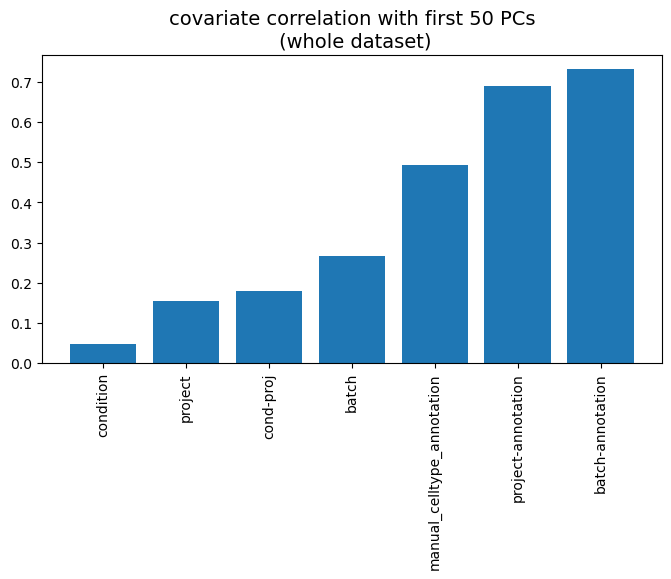

In [18]:
plt.figure(figsize=(8, 4))
plt.bar(
    total_variance_explained_clean[::-1].index,
    total_variance_explained_clean[::-1].values,
)
plt.title(
    "covariate correlation with first 50 PCs\n (whole dataset)",
    fontsize=14,
) 
plt.xticks(rotation=90)
plt.show()

The greatest effect can be seen within the cell types. This effect is a biological effect that we do not want to correct.
In order to be able to compare the other groupings better, the values in connection with the annotation of the cell types are removed. 

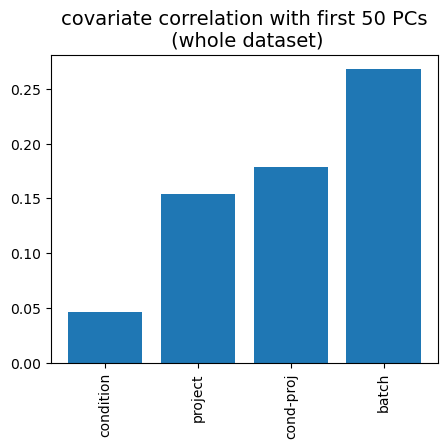

In [19]:
total_variance_explained_clean_without_annotation = total_variance_explained_clean[3:]
plt.figure(figsize=(5, 4))
plt.bar(
    total_variance_explained_clean_without_annotation[::-1].index,
    total_variance_explained_clean_without_annotation[::-1].values,
)
plt.title(
    "covariate correlation with first 50 PCs\n (whole dataset)",
    fontsize=14,
)  # \n({dominant_type})
plt.xticks(rotation=90)
plt.show()

## Compare the effects with the effects visible in a shuffled annotation 

In [28]:
groups = [
    "project", # ['xie', 'peyser', 'tsukui', 'misharin', 'schiller']
    "condition", # ['untreated', 'asbestos', 'bleomycin', 'nintedanib', 'saline']
    "cond-proj"
]

stdev_single_cell_platform_shuffled = {}
for group in groups:
    total_variance_explained_clean[f"shuffled_{group}"] = np.mean(
        total_variance_explained_fractions[
            [
                x
                for x in total_variance_explained_fractions.index
                if x.startswith(f"shuffled_{group}")
            ]
        ]
    )
    
    stdev_single_cell_platform_shuffled[f"shuffled_{group}"] = np.std(
        total_variance_explained_fractions[
            [
                x
                for x in total_variance_explained_fractions.index
                if x.startswith(f"shuffled_{group}")
            ]
        ]
    )
    
stdev_single_cell_platform_shuffled

{'shuffled_project': 0.01367497416943538,
 'shuffled_condition': 0.01540627710862822,
 'shuffled_cond-proj': 0.012704562396244826}

In [21]:
total_variance_explained_clean.sort_values(ascending=False, inplace=True)

In [22]:
total_variance_explained_clean

batch-annotation              0.732008
project-annotation            0.689964
manual_celltype_annotation    0.494596
batch                         0.267586
cond-proj                     0.178853
project                       0.153771
shuffled_cond-proj            0.079656
condition                     0.046761
shuffled_project              0.033054
shuffled_condition            0.031961
dtype: object

Plot:

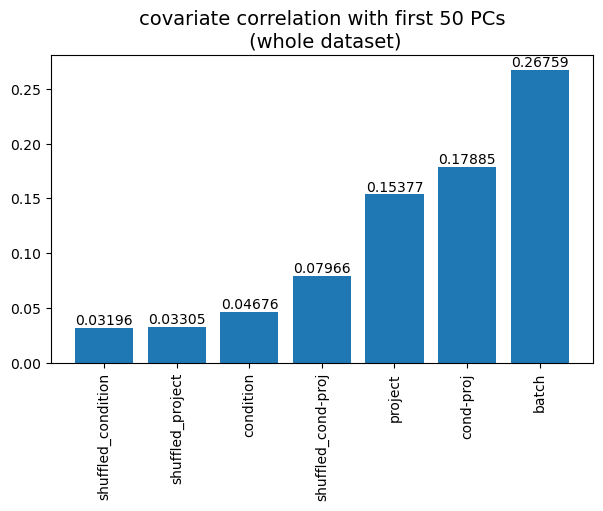

In [36]:
total_variance_explained_clean_without_annotation = total_variance_explained_clean[3:]

plt.figure(figsize=(7, 4))
rounded_values = total_variance_explained_clean_without_annotation[::-1].values.astype('float').round(5)
plt.bar(
    total_variance_explained_clean_without_annotation[::-1].index,
    rounded_values,
)

# Add rounded numbers on top of the bars
for i, value in enumerate(rounded_values):
    plt.text(i, value, str(value), ha='center', va='bottom')

plt.title(
    "covariate correlation with first 50 PCs\n (whole dataset)",
    fontsize=14,
)
plt.xticks(rotation=90)
plt.show()


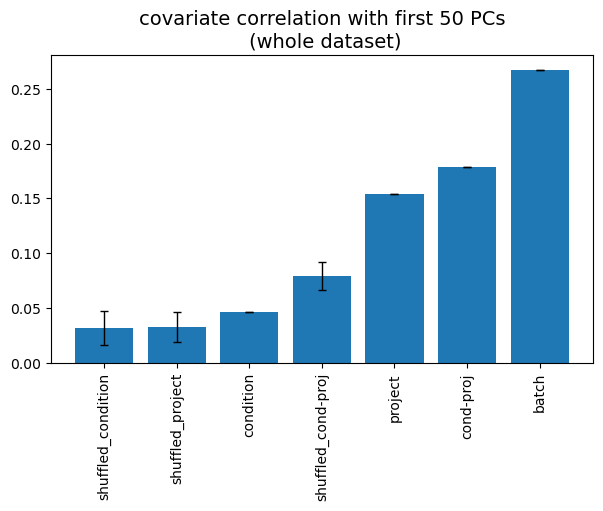

In [37]:
std_values = [stdev_single_cell_platform_shuffled['shuffled_condition'], 
              stdev_single_cell_platform_shuffled['shuffled_project'], 
              0.0,
              stdev_single_cell_platform_shuffled['shuffled_cond-proj'], 
              0.0, 0.0, 0.0]  # Beispielwerte, bitte anpassen

plt.figure(figsize=(7, 4))
rounded_values = total_variance_explained_clean_without_annotation[::-1].values.astype('float').round(5)
x_values = np.arange(len(rounded_values))

plt.bar(x_values,rounded_values,)

# Add standard deviation values as error bars
plt.errorbar(x_values, rounded_values, yerr=std_values, fmt='none', ecolor='black', elinewidth=1, capsize=3)

plt.title("covariate correlation with first 50 PCs\n (whole dataset)", fontsize=14,)
plt.xticks(x_values, total_variance_explained_clean_without_annotation[::-1].index, rotation=90)
plt.show()


### Store results:

In [39]:
res = pd.DataFrame(total_variance_explained_clean)
res.columns = ["fraction_of_variance_explained"]
for group in groups:
    res.loc[f"shuffled_{group}", "stdev"] = stdev_single_cell_platform_shuffled[f"shuffled_{group}"]

res

,fraction_of_variance_explained,stdev
batch-annotation,0.732008,NaN
project-annotation,0.689964,NaN
manual_celltype_annotation,0.494596,NaN
batch,0.267586,NaN
cond-proj,0.178853,NaN
project,0.153771,NaN
shuffled_cond-proj,0.079656,0.012705
condition,0.046761,NaN
shuffled_project,0.033054,0.013675
shuffled_condition,0.031961,0.015406


In [40]:
res.to_csv(
    f"{dir_out}/variance_explained_per_covariate.csv"
)

print z-score:

In [42]:
for group in groups:
    print(group)
    print(
        (res.loc[group, "fraction_of_variance_explained"]
        - res.loc[f"shuffled_{group}", "fraction_of_variance_explained"]
        ) / res.loc[f"shuffled_{group}", "stdev"]

    )

project
8.827584492446892
condition
0.9606752588062388
cond-proj
7.807996596967756
